<img src='https://storage.googleapis.com/kaggle-competitions/kaggle/6322/logos/header.png' alt='Forest' width="600">

**<h1> Planet: Understanding the Amazon from Space </h1>**


Source: https://www.kaggle.com/nikitarom/planets-dataset

> Use satellite data to track the human footprint in the Amazon rainforest.

---

# 0. Setup enviroment

In [ ]:
!pip install -U plotly

In [134]:
from google.colab import drive
import os
import pandas as pd
import plotly
import re
import PIL
from PIL import ImageOps
from PIL import Image
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.metrics import silhouette_score
from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD
from keras.constraints import maxnorm

In [6]:
pd.options.plotting.backend = 'plotly'

In [7]:
working_path = '/content/drive/MyDrive/Colab Notebooks/amazon'

data_path = f'{working_path}/data'
unzip_data_path = f'{data_path}/planet/planet'

train_folder = 'train-jpg'
info_file = 'train_classes.csv'

 ## 0.1 Mounting Google Drive

In [8]:
drive.mount('/content/drive')

Mounted at /content/drive


## 0.2 **(optional)** Download data with Kaggle API and unzip file

In [9]:
# set data path
os.chdir(data_path)

In [10]:
# credentials from Kaggle
os.environ['KAGGLE_USERNAME'] = 'xxxxx' # username from the json file
os.environ['KAGGLE_KEY'] = 'xxxxx' # key from the json file

In [7]:
!kaggle datasets download -d nikitarom/planets-dataset

401 - Unauthorized


In [ ]:
file_path = f'{data_path}/planets-dataset.zip'

!unzip '$file_path'

# 1. EDA



<img src='https://storage.googleapis.com/kaggle-competitions/kaggle/6322/media/chips.jpg' alt='Forest' width="1000">


In [11]:
data_info_path = f'{unzip_data_path}/{info_file}'

In [12]:
# load dataset info
data_info_df = pd.read_csv(data_info_path)

data_info_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [13]:
# number of pictures
data_info_df.shape

(40479, 2)

In [14]:
# frequencies
data_info_df_count = data_info_df.tags.value_counts()

data_info_df_count.describe()

count      449.000000
mean        90.153675
std        695.896878
min          1.000000
25%          1.000000
50%          3.000000
75%         12.000000
max      13636.000000
Name: tags, dtype: float64

In [15]:
data_info_df_count

clear primary                                                      13636
partly_cloudy primary                                               3630
cloudy                                                              2089
clear primary water                                                 1850
agriculture clear primary road                                      1680
                                                                   ...  
cultivation partly_cloudy primary selective_logging                    1
agriculture bare_ground clear conventional_mine habitation road        1
bare_ground blow_down clear primary slash_burn                         1
artisinal_mine partly_cloudy water                                     1
agriculture bare_ground clear cultivation primary road water           1
Name: tags, Length: 449, dtype: int64

In [16]:
(data_info_df_count[data_info_df_count > data_info_df_count.quantile(0.95)]
 .plot(kind='bar', 
       labels={
           'value': 'Frequency',
           'index': 'Tag'
           },
       title='Tags frequencies'))

In [17]:
# clear frequencies
data_clear = (data_info_df_count[data_info_df_count > data_info_df_count.quantile(0.90)]
              .reset_index()
              .apply(lambda row: row if 'clear' in row['index'] else None, axis=1)
              .dropna())

(data_clear
 .plot(kind='bar',
       x = 'index',
       y = 'tags',
       labels={
           'tags': 'Frequency',
           'index': 'Tag'
           },
       title='Tags frequencies')
 )

# 2. Select Tags

In [18]:
no_human = ['clear primary', 'clear primary water', 'bare_ground clear primary', 'blooming clear primary']

no_human

['clear primary',
 'clear primary water',
 'bare_ground clear primary',
 'blooming clear primary']

In [19]:
regex_human = r'agriculture|cultivation|road|selective_logging|habitation'

human = list(data_clear['index']
             .apply(lambda tag: tag if re.search(regex_human, tag) else None)
             .dropna()
             )

human

['agriculture clear primary road',
 'agriculture clear primary',
 'agriculture clear cultivation primary',
 'agriculture clear habitation primary road',
 'agriculture clear primary water',
 'clear primary road water',
 'clear cultivation primary',
 'agriculture clear primary road water',
 'agriculture clear cultivation primary road',
 'agriculture clear cultivation habitation primary road',
 'agriculture clear habitation primary road water',
 'clear primary road',
 'agriculture clear cultivation primary water',
 'clear habitation primary road',
 'agriculture clear habitation primary',
 'clear cultivation primary water',
 'agriculture clear cultivation habitation primary',
 'clear habitation primary road water',
 'clear primary selective_logging',
 'agriculture clear cultivation primary road water',
 'clear primary road selective_logging',
 'agriculture clear habitation primary water']

## 2.1 Filter DF

In [20]:
def add_condition(row: any, col_tags: str, human_tags: list, no_human_tags: list) -> any:
    human = ['^' + tag + '$' for tag in human_tags]
    no_human = ['^' + tag + '$' for tag in no_human_tags]

    regex_all_human = '|'.join(human)
    regex_all_no_human = '|'.join(no_human)

    if re.search(regex_all_human, row[col_tags]):
        return 'human'
    elif re.search(regex_all_no_human, row[col_tags]):
        return 'no_human'
    else:
        return None

data_info_filtered_df = data_info_df

data_info_filtered_df['tags']

data_info_filtered_df['type'] = (data_info_df
                                 .apply(lambda row: add_condition(row, 'tags', human, no_human), axis=1)
                                 )

data_info_filtered_df = data_info_filtered_df.dropna()

data_info_filtered_df.head()


,image_name,tags,type
1,train_1,agriculture clear primary water,human
2,train_2,clear primary,no_human
3,train_3,clear primary,no_human
4,train_4,agriculture clear habitation primary road,human
6,train_6,agriculture clear cultivation primary water,human


In [21]:
data_info_filtered_df.shape

(25999, 3)

In [22]:
(data_info_filtered_df['type']
 .value_counts()
 .plot(kind='bar',
       labels={
                   'value': 'Frequency',
           'index': 'Tag'
           },
       title='Tags frequencies'))

# 3. Get paths

In [23]:
train_path = f'{unzip_data_path}/{train_folder}'

train_path

'/content/drive/MyDrive/Colab Notebooks/amazon/data/planet/planet/train-jpg'

In [24]:
# create path column
data_info_filtered_df['path'] = (data_info_filtered_df
                                 .image_name
                                 .apply(lambda file_name: f'{train_path}/{file_name}.jpg'))

data_info_filtered_df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,image_name,tags,type,path
1,train_1,agriculture clear primary water,human,/content/drive/MyDrive/Colab Notebooks/amazon/...
2,train_2,clear primary,no_human,/content/drive/MyDrive/Colab Notebooks/amazon/...
3,train_3,clear primary,no_human,/content/drive/MyDrive/Colab Notebooks/amazon/...
4,train_4,agriculture clear habitation primary road,human,/content/drive/MyDrive/Colab Notebooks/amazon/...
6,train_6,agriculture clear cultivation primary water,human,/content/drive/MyDrive/Colab Notebooks/amazon/...


# 4. Visualization

In [27]:
def img_vis(type_tag: str, index: int) -> any:
    img = PIL.Image.open(data_info_filtered_df[data_info_filtered_df['type'] == type_tag]
                        .path
                        .iloc[index])

    img_gray = ImageOps.grayscale(img)

    img_np = np.array(img_gray)

    return img_np

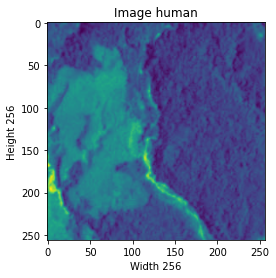

In [28]:
label = 'human'

img_np = img_vis(label, 0)

plt.title(f'Image {label}')
plt.ylabel('Height {}'.format(img_np.shape[0]))
plt.xlabel('Width {}'.format(img_np.shape[1]))
plt.imshow(img_np);

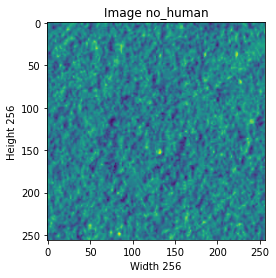

In [ ]:
label = 'no_human'

img_np = img_vis(label, 0)

plt.title(f'Image {label}')
plt.ylabel('Height {}'.format(img_np.shape[0]))
plt.xlabel('Width {}'.format(img_np.shape[1]))
plt.imshow(img_np);

# 5. Sample

## 5.1 Random sampling

In [29]:
seed = 25
n = 7617

samp_df = (data_info_filtered_df
           .groupby('type', group_keys=False)
           .apply(lambda x: x.sample(n))
)

samp_df

,image_name,tags,type,path
27209,train_27209,agriculture clear primary road,human,/content/drive/MyDrive/Colab Notebooks/amazon/...
20112,train_20112,agriculture clear cultivation primary,human,/content/drive/MyDrive/Colab Notebooks/amazon/...
40054,train_40054,clear primary road water,human,/content/drive/MyDrive/Colab Notebooks/amazon/...
22315,train_22315,agriculture clear cultivation habitation prima...,human,/content/drive/MyDrive/Colab Notebooks/amazon/...
211,train_211,clear habitation primary road,human,/content/drive/MyDrive/Colab Notebooks/amazon/...
...,...,...,...,...
26078,train_26078,clear primary water,no_human,/content/drive/MyDrive/Colab Notebooks/amazon/...
20059,train_20059,clear primary,no_human,/content/drive/MyDrive/Colab Notebooks/amazon/...
8409,train_8409,clear primary,no_human,/content/drive/MyDrive/Colab Notebooks/amazon/...
3294,train_3294,clear primary,no_human,/content/drive/MyDrive/Colab Notebooks/amazon/...


## 5.2 Split data

In [30]:
X = samp_df.path

le = preprocessing.LabelEncoder()
y = le.fit_transform(samp_df['type']).reshape(-1, 1)

seed = 64

# downsampling because size
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.7,
                                                    random_state=seed,
                                                    stratify=y)

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X_train,
                                                    y_train,
                                                    test_size = 0.1,
                                                    random_state=seed,
                                                    stratify=y_train)

In [31]:
labels = list(le.inverse_transform([0, 1]))

labels

['human', 'no_human']

In [42]:
file_path = f'{working_path}/y_train.npy'

np.save(file_path, y_train)

In [43]:
file_path = f'{working_path}/y_test.npy'

np.save(file_path, y_test)

# 6. Load data

In [32]:
def load_data(img_path: pd.Series, width: int = 256, height: int = 256) -> np.ndarray:
    len_vec = width * height
    
    img_path_list = img_path.to_list()
    len_path_list = len(img_path_list)

    img_list_all = []
    for i in range(len_path_list):
        img = Image.open(img_path_list[i])
        img = ImageOps.grayscale(img)
        img = np.asarray(img) / 255.0
        img = img.reshape((len_vec, 1))
        img_list_all.append(img)

        print( i / len_path_list)
        
    img_array = np.array(img_list_all)

    return img_array.reshape(-1, len_vec)

In [33]:
# load traing img
X_train_img = load_data(X_train)

In [34]:
X_train_img.shape

(4113, 65536)

In [40]:
file_path = f'{working_path}/X_train_img.npy'

np.save(file_path, X_train_img)

In [ ]:
# load test img
X_test_img = load_data(X_test)

In [36]:
X_test_img.shape

(457, 65536)

In [41]:
file_path = f'{working_path}/X_test_img.npy'

np.save(file_path, X_test_img)

# 7. Pipeline PCA -> KMeans

## 7.1 Train

In [ ]:
def train_pipe(X_train: np.ndarray, y_train: list , parameters: dict, k: int) -> any:
    
    estimators = [
                  ('pca', PCA()),
                  ('kmeans', KMeans())
                  ]
    pipe_art = Pipeline(estimators)
    metric_clu = make_scorer(silhouette_score)
    grid = GridSearchCV(pipe_art, parameters, cv=k, scoring=metric_clu)
    grid_search = grid.fit(X_train, y_train)

    return grid_search

In [ ]:
parameters = {
    'pca__n_components': [2, 5, 10, 25],
    'kmeans__n_clusters': [2]
}

## 7.2 Hyperparameters

In [ ]:
gsearch = train_pipe(X_train_img, y_train, parameters, k=10)

In [ ]:
print(f"Silhouette_score (val): {gsearch.best_score_}")
print("Best configuration:")

best_parameters = gsearch.best_params_
for param in sorted(parameters.keys()):
    print(f"\t{param}: {best_parameters[param]}")

Silhouette_score (val): 0.1933165584536794
Best configuration:
	kmeans__n_clusters: 2
	pca__n_components: 10


## 7.3 Results

In [ ]:
# test prediction
y_test_clustering = gsearch.predict(X_test_img)

In [ ]:
# get metric
confusion_matrix = sklearn.metrics.confusion_matrix(y_test, y_test_clustering, normalize='true')

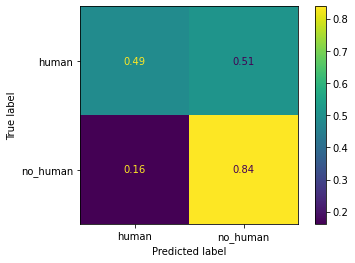

In [ ]:
# display matrix
matrix_plot = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix, labels)

matrix_plot.plot()

# 8. ANN

## 8.1 Model

In [143]:
X_train_resha = X_train_img.reshape((-1, 256, 256, 1))

In [144]:
X_train_img.shape

(4113, 65536)

In [145]:
X_train_resha.shape

(4113, 256, 256, 1)

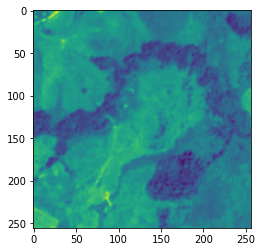

In [148]:
plt.imshow(X_train_resha[10,:,:,0]);

In [149]:
def create_model():
    # default values
    activation='relu'
    dropout_rate=0.1
    optimizer='adam'
    input_dim = [256, 256, 1]

    # create model
    model = Sequential()
    model.add(Conv2D(2, 3, activation='relu', input_shape=input_dim))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model, batch_size=10, epochs=5)

## 8.2 Train

In [150]:
y_train = y_train.reshape((-1,))

In [151]:
result = model.fit(X_train_resha, y_train)

Epoch 1/5
412/412 [==============================] - 72s 175ms/step - loss: 0.5881 - accuracy: 0.7099
Epoch 2/5
412/412 [==============================] - 75s 181ms/step - loss: 0.5162 - accuracy: 0.7656
Epoch 3/5
412/412 [==============================] - 72s 175ms/step - loss: 0.4686 - accuracy: 0.7984
Epoch 4/5
412/412 [==============================] - 72s 175ms/step - loss: 0.4710 - accuracy: 0.8079
Epoch 5/5
412/412 [==============================] - 72s 175ms/step - loss: 0.4224 - accuracy: 0.8296


## 8.3 Results

In [152]:
X_test_resha = X_test_img.reshape((-1, 256, 256, 1))
y_test = y_test.reshape((-1,))

In [154]:
# test prediction
y_test_predict = model.predict(X_test_resha)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [162]:
# get metric
confusion_matrix = sklearn.metrics.confusion_matrix(y_test, y_test_predict, normalize='true')

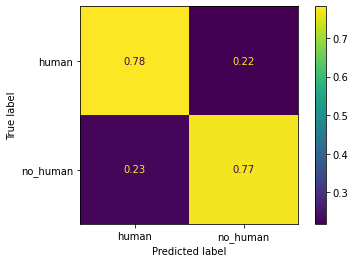

In [163]:
# display matrix
matrix_plot = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix, labels)

matrix_plot.plot()